In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# LSTM Model Definition with Dropout to reduce overfitting
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # Define LSTM layer with Dropout
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_prob)

        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initializing hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial cell state

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Pass the output of the last timestep to the fully connected layer
        out = self.fc(out[:, -1, :])  # Using the output from the last time step for prediction
        return out

In [3]:
# Parse the .v file to extract relevant data
def parse_v_file(file_path):
    features = []
    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if line.startswith("//"):  # Skip comments
            continue
        parts = line.split()  # Split by space/tab
        if len(parts) > 1:
            try:
                # Convert the relevant values into integers (skip non-numeric parts)
                features.append([int(x) for x in parts if x.isdigit()])
            except ValueError:
                continue

    return np.array(features)

In [4]:
# Load data from the .v file
file_path = '/content/s9234.v'
data_array = parse_v_file(file_path)

# Ensure the data tensor has the shape [batch_size, sequence_length, input_size]
data_tensor = torch.tensor(data_array, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension

# Example target output (simulated for this task, adjust as per actual needs)
target = torch.tensor([[1.0, 0.5, 0.2]] * data_array.shape[0], dtype=torch.float32)  # Example output (3517 rows)

In [5]:
# Hyperparameters
input_size = data_array.shape[1]  # Number of features per time step
hidden_size = 64  # Reduce hidden size to reduce model complexity
output_size = 3  # Number of outputs (you can adjust this)
num_epochs = 50  # Reduce number of epochs
learning_rate = 0.001  # Learning rate

In [6]:
# Initialize the model with dropout regularization
model = LSTMModel(input_size, hidden_size, output_size, dropout_prob=0.3)

# Loss and optimizer
criterion = nn.MSELoss()  # Assuming regression task
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Adding weight decay

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(data_tensor)  # Forward pass
    loss = criterion(outputs, target)  # Compute loss

    optimizer.zero_grad()  # Zero the gradients
    loss.backward()  # Backpropagate
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5818, 3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.3751
Epoch [20/50], Loss: 0.1853
Epoch [30/50], Loss: 0.0145
Epoch [40/50], Loss: 0.0094
Epoch [50/50], Loss: 0.0029


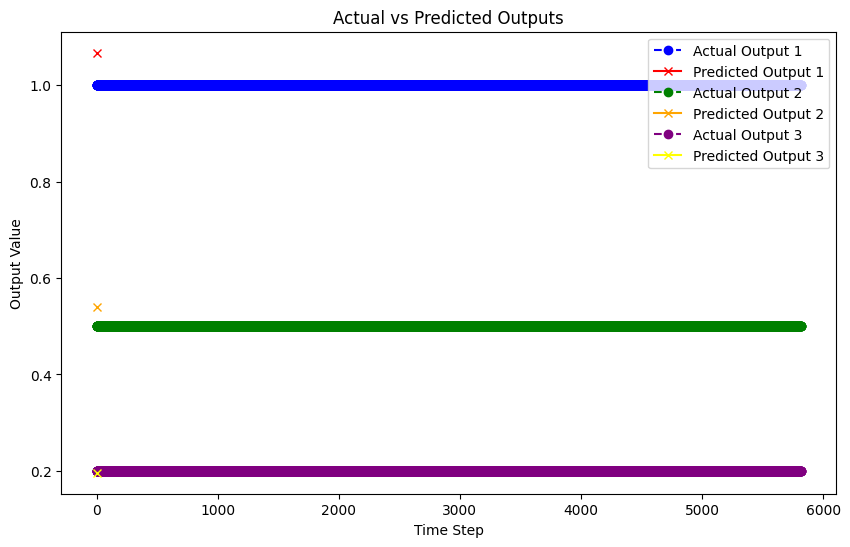

In [7]:
model.eval()
with torch.no_grad():
    predicted_output = model(data_tensor)

# Convert predicted and actual output to numpy for easier plotting
predicted_output_np = predicted_output.numpy()
target_np = target.numpy()

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))

# Plot the first target output vs predicted output
plt.plot(target_np[:, 0], label='Actual Output 1', color='blue', linestyle='--', marker='o')
plt.plot(predicted_output_np[:, 0], label='Predicted Output 1', color='red', linestyle='-', marker='x')

# Plot the second target output vs predicted output
plt.plot(target_np[:, 1], label='Actual Output 2', color='green', linestyle='--', marker='o')
plt.plot(predicted_output_np[:, 1], label='Predicted Output 2', color='orange', linestyle='-', marker='x')

# Plot the third target output vs predicted output
plt.plot(target_np[:, 2], label='Actual Output 3', color='purple', linestyle='--', marker='o')
plt.plot(predicted_output_np[:, 2], label='Predicted Output 3', color='yellow', linestyle='-', marker='x')

# Add labels and legend
plt.xlabel('Time Step')
plt.ylabel('Output Value')
plt.title('Actual vs Predicted Outputs')
plt.legend()

# Show the plot
plt.show()